## MLG18

In [1]:
from pandas import DataFrame
from pandas import read_csv
from keras.models import Sequential
from keras.layers import LSTM, GRU
from keras.layers import Dense
from matplotlib import pyplot
from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import StandardScaler

dataset = read_csv('LOAD.csv', header=0, index_col=0).iloc[::-1]

/home/yasas/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Normalizing with Standard Scaler

In [2]:
dataset[dataset.columns] = StandardScaler().fit_transform(dataset)

### Shifting Dataset and Creating a Dataset for Model Training and Testing

In [3]:
dataset_shifted = dataset.shift(-5)
dataset = dataset.iloc[:-5]
dataset_shifted = dataset_shifted.iloc[:-5]

### Dividing the Dataset for Training and Testing

In [4]:
train_dataset = dataset.iloc[:-500]
train_dataset_shifted = dataset_shifted.iloc[:-500]

test_dataset = dataset.iloc[-500:]
test_dataset_shifted = dataset_shifted.iloc[-500:]

### Finding Optimal Paramers

In [5]:
# from sklearn.model_selection import GridSearchCV
# from keras.wrappers.scikit_learn import KerasClassifier
# import copy

# def fit_lstm_tuning(activation, recurrent_activation, loss, optimizer):
#     model_lstm = Sequential()
#     model_lstm.add(LSTM(1, input_shape=(1, dataset.shape[1]), activation = activation, recurrent_activation = recurrent_activation))
#     model_lstm.add(Dense(1))
#     model_lstm.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])
#     return model_lstm

# activations = ['softmax', 'elu', 'selu', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
# recurrent_activations = ['softmax', 'elu', 'selu', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']

# optimizers = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
# losses = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'mean_squared_logarithmic_error', 'squared_hinge', 'hinge', 'categorical_hinge', 'logcosh', 'categorical_crossentropy', 'sparse_categorical_crossentropy', 'binary_crossentropy', 'kullback_leibler_divergence', 'poisson', 'cosine_proximity']

# X = copy.deepcopy(train_dataset.values.reshape((train_dataset.shape[0], 1, train_dataset.shape[1])))
# Y = copy.deepcopy(train_dataset_shifted['system.load.5'])

# model = KerasClassifier(build_fn=fit_lstm_tuning)

# param_grid = dict(activation = activations, recurrent_activation = recurrent_activations, optimizer = optimizers, loss = losses)

# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1)
# grid_result = grid.fit(X,Y)

# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

### Training LSTM

In [6]:
model_lstm = Sequential()
model_lstm.add(LSTM(1, input_shape=(1, dataset.shape[1])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mae', optimizer='adam')

model_lstm.fit(train_dataset.values.reshape((train_dataset.shape[0], 1, train_dataset.shape[1])), train_dataset_shifted['system.load.5'])

Epoch 1/1
19918/19918 [==============================] - 6s 317us/step - loss: 0.2830


### Training GRU

In [7]:
model_gru = Sequential()
model_gru.add(GRU(1, input_shape=(1, dataset.shape[1])))
model_gru.add(Dense(1))
model_gru.compile(loss='mae', optimizer='adam')

model_gru.fit(train_dataset.values.reshape((train_dataset.shape[0], 1, train_dataset.shape[1])), train_dataset_shifted['system.load.5'])

Epoch 1/1
19918/19918 [==============================] - 5s 273us/step - loss: 0.3359


### Predicting Values

In [8]:
test_dataset_predicted_lstm = model_lstm.predict(test_dataset.values.reshape((test_dataset.shape[0], 1, test_dataset.shape[1])))
test_dataset_predicted_gru = model_gru.predict(test_dataset.values.reshape((test_dataset.shape[0], 1, test_dataset.shape[1])))

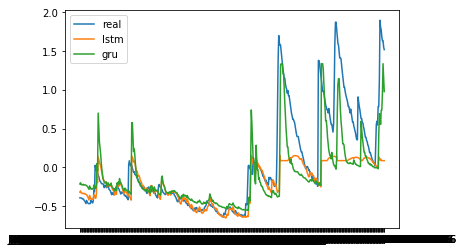

In [9]:
pyplot.plot(test_dataset_shifted['system.load.5'], label='real')
pyplot.plot(test_dataset_predicted_lstm, label='lstm')
pyplot.plot(test_dataset_predicted_gru, label='gru')
pyplot.legend()
pyplot.show()

In [10]:
mean_absolute_error(test_dataset_predicted_lstm, test_dataset_shifted['system.load.5'])

0.27689464103159195

In [11]:
mean_absolute_error(test_dataset_predicted_gru, test_dataset_shifted['system.load.5'])

0.25594868712926383